In [1]:
import random
from copy import deepcopy
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.norm as norm
from autograd import grad
from autograd.misc import flatten

from autograd.misc.optimizers import SGD

import gym
import roboschool

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class NormalizedActions(gym.ActionWrapper):

    def _action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        
        return action

    def _reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = 2.0 * (action - low_bound) / (upper_bound - low_bound) - 1.0
        action = np.clip(action, low_bound, upper_bound)
        
        return actions

In [4]:
from multiprocessing_env import SubprocVecEnv
env_name = "RoboschoolInvertedPendulumSwingup-v1"
# env_name = "RoboschoolInvertedPendulum-v1"

env = NormalizedActions(gym.make(env_name))

num_states  = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

/home/anon/src/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/anon/src/gym/gym/logger.py:30: UserWarning: WARN: Environment '<class 'roboschool.gym_pendulums.RoboschoolInvertedPendulumSwingup'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [6]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)
    
#https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py

In [7]:
def init_param(scale, layer_sizes, rs=npr):#.RandomState(345)):
    return [[rs.randn(insize, outsize) * scale, 
             rs.randn(outsize) * scale]
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

def relu(x):
    return np.maximum(x, 0.)

def Qfunc(q_params, s, a): # Q function
    q = np.concatenate((s, a), -1)
    for W, b in q_params[:-1]:
        q = np.dot(q, W) + b
        q = relu(q)
    W, b = q_params[-1]
    return np.dot(q, W) + b

def policy(p_params, s):
    a = s
    for W, b in p_params[:-1]:
        a = np.dot(a, W) + b
        a = relu(a)
    W, b = p_params[-1]
    a = np.dot(a, W) + b
    return np.tanh(a)

In [8]:
def value_loss(x, states, actions, targets):
    values = Qfunc(x, states, actions)
    return np.mean(np.square(values - targets))
def policy_loss(x, states, _value_params):
    policy_loss = Qfunc(_value_params, states, policy(x, states))
    return -np.mean(policy_loss)

grad_value_loss = grad(value_loss)
grad_policy_loss = grad(policy_loss)

def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

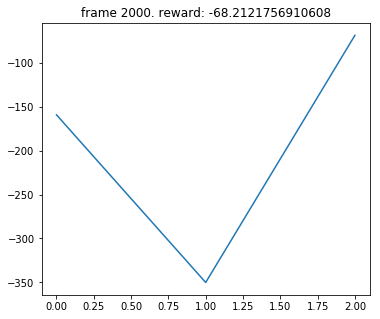

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010


KeyboardInterrupt: 

In [9]:
tf = 500
batch_size = 128
replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)
rho = 0.8
gamma = 0.99

policy_sizes = [num_states] + [256, 256] + [num_actions]
value_sizes = [num_states+num_actions] + [256, 256] + [1]

# init_w = 3e-3
policy_params = init_param(0.1, policy_sizes)
# W,b = policy_params[-1]
# W = npr.uniform(-init_w, init_w, size=W.shape)
# b = npr.uniform(-init_w, init_w, size=b.shape)
# policy_params[-1] = [W, b]

value_params = init_param(0.1, value_sizes)
# W,b = value_params[-1]
# W = npr.uniform(-init_w, init_w, size=W.shape)
# b = npr.uniform(-init_w, init_w, size=b.shape)
# value_params[-1] = [W, b]

target_policy_params = deepcopy(policy_params)
target_value_params = deepcopy(value_params)


policy_optimizer = SGD(policy_params, step_size=1e-3)
value_optimizer = SGD(value_params, step_size=1e-3)

ou_noise = OUNoise(env.action_space)

reward_history = []
max_frame = 20000
frame_idx = 0
while frame_idx < max_frame:

    state = env.reset()
    ou_noise.reset()
    episode_reward = 0

    for t in range(tf):
        action = policy(policy_params, state) 
        action = ou_noise.get_action(action, t)
        # step forward
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        
        if len(replay_buffer) > batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            rewards = rewards.reshape((-1,1))
            dones = dones.reshape((-1,1))
            values = Qfunc(target_value_params, next_states, 
                            policy(target_policy_params, next_states))
            targets = rewards + gamma * (1.0 - dones) * values
            policy_update = lambda x, i: grad_policy_loss(x, states, value_params)
            value_update = lambda x, i: grad_value_loss(x, states, actions, targets)

            policy_params = policy_optimizer.step(policy_update, policy_params)
            value_params = value_optimizer.step(value_update, value_params)
            
            _target_policy_params, unflatten_policy = flatten(target_policy_params)
            _target_value_params, unflatten_value = flatten(target_value_params)
            
            _policy_params, _ = flatten(policy_params)
            _value_params, _ = flatten(value_params)
            
            _target_policy_params = rho * _target_policy_params \
                                        + (1.0-rho)*_policy_params
            _target_value_params = rho * _target_value_params \
                                        + (1.0-rho)*_value_params
            
            target_value_params = unflatten_value(_target_value_params.copy())
            target_policy_params = unflatten_policy(_target_policy_params.copy())
            
            
            
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if frame_idx % max(1000, tf+1) == 0:
            plot(frame_idx, reward_history)
        
        if done:
            break
    reward_history.append(episode_reward)
    

In [ ]:
state = env.reset()
for t in range(tf):
    a = policy(policy_params, state) 
    state, reward, done, _ = env.step(a)
    env.render()